In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklego.linear_model import LowessRegression
import numpy as np
import seaborn as sns
from scipy.interpolate import UnivariateSpline
from scipy import stats

In [2]:
# load metadata
metadata = pd.read_csv("/Users/dagmarschierova/MEGA/MBÚ/TNF/NGS/runs_merged/inputs/metadata_stool.tsv", sep='\t')
metadata = metadata.iloc[1:]
metadata.set_index('#SampleID', inplace=True)
metadata

,Label,Plate,Position,Patient,Age,Sex,Height,Weight,BMI,BMI_category,...,Response_scale3_Start_end,Dg_Response_scale2_Start_end,Disease_severity_scale2_Start_end,Disease_severity_scale4_Start_end,Response_scale2_Start_end_combined,Response_scale3_Start_end_combined,Dg_Response_scale2_Start_end_combined,Disease_severity_scale2_Start_end_combined,Disease_severity_scale4_Start_end_combined,Dg_Week38
#SampleID,,,,,,,,,,,,,,,,,,,,,
1_BA_1,1_BA_1,B1,A1,P1,25,F,170,77,26.6,overweight,...,baseline_start,CD_no_response_start,inactive_start,mild_start,no_response_start,baseline_start,CD_no_response_start,inactive_start,mild_start,CD_week_0
1_BA_2,1_BA_2,B1,B1,P1,25,F,170,77,26.6,overweight,...,full_response_NA,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_2
1_BA_3,1_BA_3,B1,C1,P1,25,F,170,78,27,overweight,...,full_response_NA,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_8
1_BA_4,1_BA_4,B1,D1,P1,25,F,170,79,27.3,overweight,...,full_response_NA,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_14
1_BA_5,1_BA_5,B1,E1,P1,25,F,170,80,27.7,overweight,...,full_response_NA,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mock_4_DNA,mock_4_DNA,B2,B12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21_PP_8_ADA,21_PP_8_ADA,B2,E12,P21_ADA,25,F,165,64,23.5,normal,...,NaN,CD_NA,NaN,NaN,NaN,NaN,CD_NA,NaN,NaN,CD_NA
P72_DM_7,P72_DM_7,B2,F12,P72,34,F,175,56,18.3,underweight,...,full_response_end,CD_response_end,inactive_end,remission_end,response_end,full_response_end,CD_response_end,inactive_end,remission_end,CD_week_38


In [3]:
# load shannon diversity values
shannon = pd.read_csv("/Users/dagmarschierova/MEGA/MBÚ/TNF/NGS/runs_merged/outputs/qiime_results_B/diversity_Large_cohort/alpha/shannon.tsv", sep='\t')
shannon = shannon.iloc[1:]
shannon.set_index('SampleID', inplace=True)
shannon

,Shannon_entropy
SampleID,
1_BA_1,5.245601555
1_BA_2,5.328261504
1_BA_3,5.230081928
1_BA_4,4.206164775
1_BA_5,4.908037192
...,...
P78_BL_8,6.070990062
P79_MM_1,5.613115942
P80_KA_1,5.015685951


In [4]:
# merge shannon with metadata
metadata = metadata.merge(shannon, how='inner', left_index=True, right_index=True)
metadata

,Label,Plate,Position,Patient,Age,Sex,Height,Weight,BMI,BMI_category,...,Dg_Response_scale2_Start_end,Disease_severity_scale2_Start_end,Disease_severity_scale4_Start_end,Response_scale2_Start_end_combined,Response_scale3_Start_end_combined,Dg_Response_scale2_Start_end_combined,Disease_severity_scale2_Start_end_combined,Disease_severity_scale4_Start_end_combined,Dg_Week38,Shannon_entropy
1_BA_1,1_BA_1,B1,A1,P1,25,F,170,77,26.6,overweight,...,CD_no_response_start,inactive_start,mild_start,no_response_start,baseline_start,CD_no_response_start,inactive_start,mild_start,CD_week_0,5.245601555
1_BA_2,1_BA_2,B1,B1,P1,25,F,170,77,26.6,overweight,...,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_2,5.328261504
1_BA_3,1_BA_3,B1,C1,P1,25,F,170,78,27,overweight,...,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_8,5.230081928
1_BA_4,1_BA_4,B1,D1,P1,25,F,170,79,27.3,overweight,...,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_14,4.206164775
1_BA_5,1_BA_5,B1,E1,P1,25,F,170,80,27.7,overweight,...,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_22,4.908037192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K22_1,K22_1,B2,G11,HC22,51,F,161,76,29.3,overweight,...,HC,HC,HC,HC,HC,HC,HC,HC,HC,6.629727629
K23_1,K23_1,B2,H11,HC23,33,M,186,95,27.5,overweight,...,HC,HC,HC,HC,HC,HC,HC,HC,HC,5.403106622
P72_DM_7,P72_DM_7,B2,F12,P72,34,F,175,56,18.3,underweight,...,CD_response_end,inactive_end,remission_end,response_end,full_response_end,CD_response_end,inactive_end,remission_end,CD_week_38,6.279090304
P53_CZ_8,P53_CZ_8,B2,G12,P53,41,F,160,74,28.9,overweight,...,CD_response_end,inactive_end,mild_end,response_end,partial_response_end,CD_response_end,inactive_end,mild_end,CD_week_46,6.446036159


In [5]:
convert_dict = {'Week_num': float,
                'Visit_num': float,
                'HBI_num': float,
                'pMayo_num': float,
                'Shannon_entropy': float
               }
  
metadata = metadata.astype(convert_dict)
print(metadata.dtypes)

Label                                          object
Plate                                          object
Position                                       object
Patient                                        object
Age                                            object
                                               ...   
Dg_Response_scale2_Start_end_combined          object
Disease_severity_scale2_Start_end_combined     object
Disease_severity_scale4_Start_end_combined     object
Dg_Week38                                      object
Shannon_entropy                               float64
Length: 133, dtype: object


In [6]:
# filter out CD patients only
cd = metadata[(metadata['Dg']=='CD') & (-metadata["Label"].isin(['P53_CZ_8','P71_SJ_9']))]

In [7]:
# filter out UC patients only
uc = metadata[metadata['Dg']=='UC']

In [8]:
# filter out HC only
hc = metadata[(metadata['Dg']=='HC') & (-metadata["Label"].isin(['K9_Z80_1','K11_M87_1','K20_Z76_1']))]

# Create plots with lowess

In [9]:
# create a dictionary having individual patients as keys
patients_cd = dict()
for individual in cd['Patient'].unique():
    patients_cd[individual] = cd[(cd['Patient'] == individual)][["Week_num","HBI_num","Shannon_entropy","CD_localisation"]]

patients_uc = dict()
for individual in uc['Patient'].unique():
    patients_uc[individual] = uc[(uc['Patient'] == individual)][["Week_num","pMayo_num","Shannon_entropy","UC_extent"]]

In [10]:
# sort the values according to week number and drop NA
for individual in patients_cd.keys():
    patients_cd[individual].sort_values('Week_num', inplace=True)
    patients_cd[individual].dropna(inplace=True)
    
for individual in patients_uc.keys():
    patients_uc[individual].sort_values('Week_num', inplace=True)
    patients_uc[individual].dropna(inplace=True)

In [11]:
cd_lowess = cd[['HBI_num','Shannon_entropy','Week_num']].dropna()
uc_lowess = uc[['pMayo_num','Shannon_entropy','Week_num']].dropna()

#### Model for CD HBI

In [12]:
# create a reg model
X = cd_lowess['Week_num'].to_numpy().reshape(-1,1)
y = cd_lowess['HBI_num'].to_numpy()
mod = LowessRegression(sigma=10).fit(X, y)

# predict with the model
x_pred = np.array([0,2,6,8,14,20,22,26,30,32,38]).reshape(-1, 1)
#x_pred = np.arange(start=0, stop=38.5, step=2).reshape(-1, 1)
y_pred = mod.predict(x_pred)
y_pred = pd.DataFrame(y_pred).rename(columns={0: "HBI_pred_lowess"})
y_pred

# create a df with predicted values
pred_lowess_cd_hbi = y_pred.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_cd_hbi

# calculate confidence interval
ci_cd_hbi = 1.96 * np.std(cd_lowess["HBI_num"])/np.mean(cd_lowess["HBI_num"])

#### Model for UC pMayo

In [13]:
# create a reg model
X = uc_lowess['Week_num'].to_numpy().reshape(-1,1)
y = uc_lowess['pMayo_num'].to_numpy()
mod = LowessRegression(sigma=10).fit(X, y)

# predict with the model
x_pred = np.array([0,2,6,8,14,20,22,26,30,32,38]).reshape(-1, 1)
#x_pred = np.arange(start=0, stop=38.5, step=2).reshape(-1, 1)
y_pred = mod.predict(x_pred)
y_pred = pd.DataFrame(y_pred).rename(columns={0: "pMayo_pred_lowess"})
y_pred

# create a df with predicted values
pred_lowess_uc_pmayo = y_pred.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_uc_pmayo

# calculate confidence interval
ci_uc_pmayo = 1.96 * np.std(uc_lowess["pMayo_num"])/np.mean(uc_lowess["pMayo_num"])

#### Model for CD Shannon

In [14]:
# create a reg model
X = cd_lowess['Week_num'].to_numpy().reshape(-1,1)
y = cd_lowess['Shannon_entropy'].to_numpy()
mod = LowessRegression(sigma=10).fit(X, y)

# predict with the model
x_pred = np.array([0,2,6,8,14,20,22,26,30,32,38]).reshape(-1, 1)
#x_pred = np.arange(start=0, stop=38.5, step=2).reshape(-1, 1)
y_pred = mod.predict(x_pred)
y_pred = pd.DataFrame(y_pred).rename(columns={0: "Shannon_pred_lowess"})
y_pred

# create a df with predicted values
pred_lowess_cd_shannon = y_pred.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_cd_shannon

# calculate confidence interval
ci_cd_sh = 1.96 * np.std(cd_lowess["Shannon_entropy"])/np.mean(cd_lowess["Shannon_entropy"])

#### Model for UC Shannon

In [15]:
# create a reg model
X = uc_lowess['Week_num'].to_numpy().reshape(-1,1)
y = uc_lowess['Shannon_entropy'].to_numpy()
mod = LowessRegression(sigma=10).fit(X, y)

# predict with the model
x_pred = np.array([0,2,6,8,14,20,22,26,30,32,38]).reshape(-1, 1)
#x_pred = np.arange(start=0, stop=38.5, step=2).reshape(-1, 1)
y_pred = mod.predict(x_pred)
y_pred = pd.DataFrame(y_pred).rename(columns={0: "Shannon_pred_lowess"})
y_pred

# create a df with predicted values
pred_lowess_uc_shannon = y_pred.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_uc_shannon

# calculate confidence interval
ci_uc_sh = 1.96 * np.std(uc_lowess["Shannon_entropy"])/np.mean(uc_lowess["Shannon_entropy"])

#### Plot clinical scores and Shannon in time with lowess fit

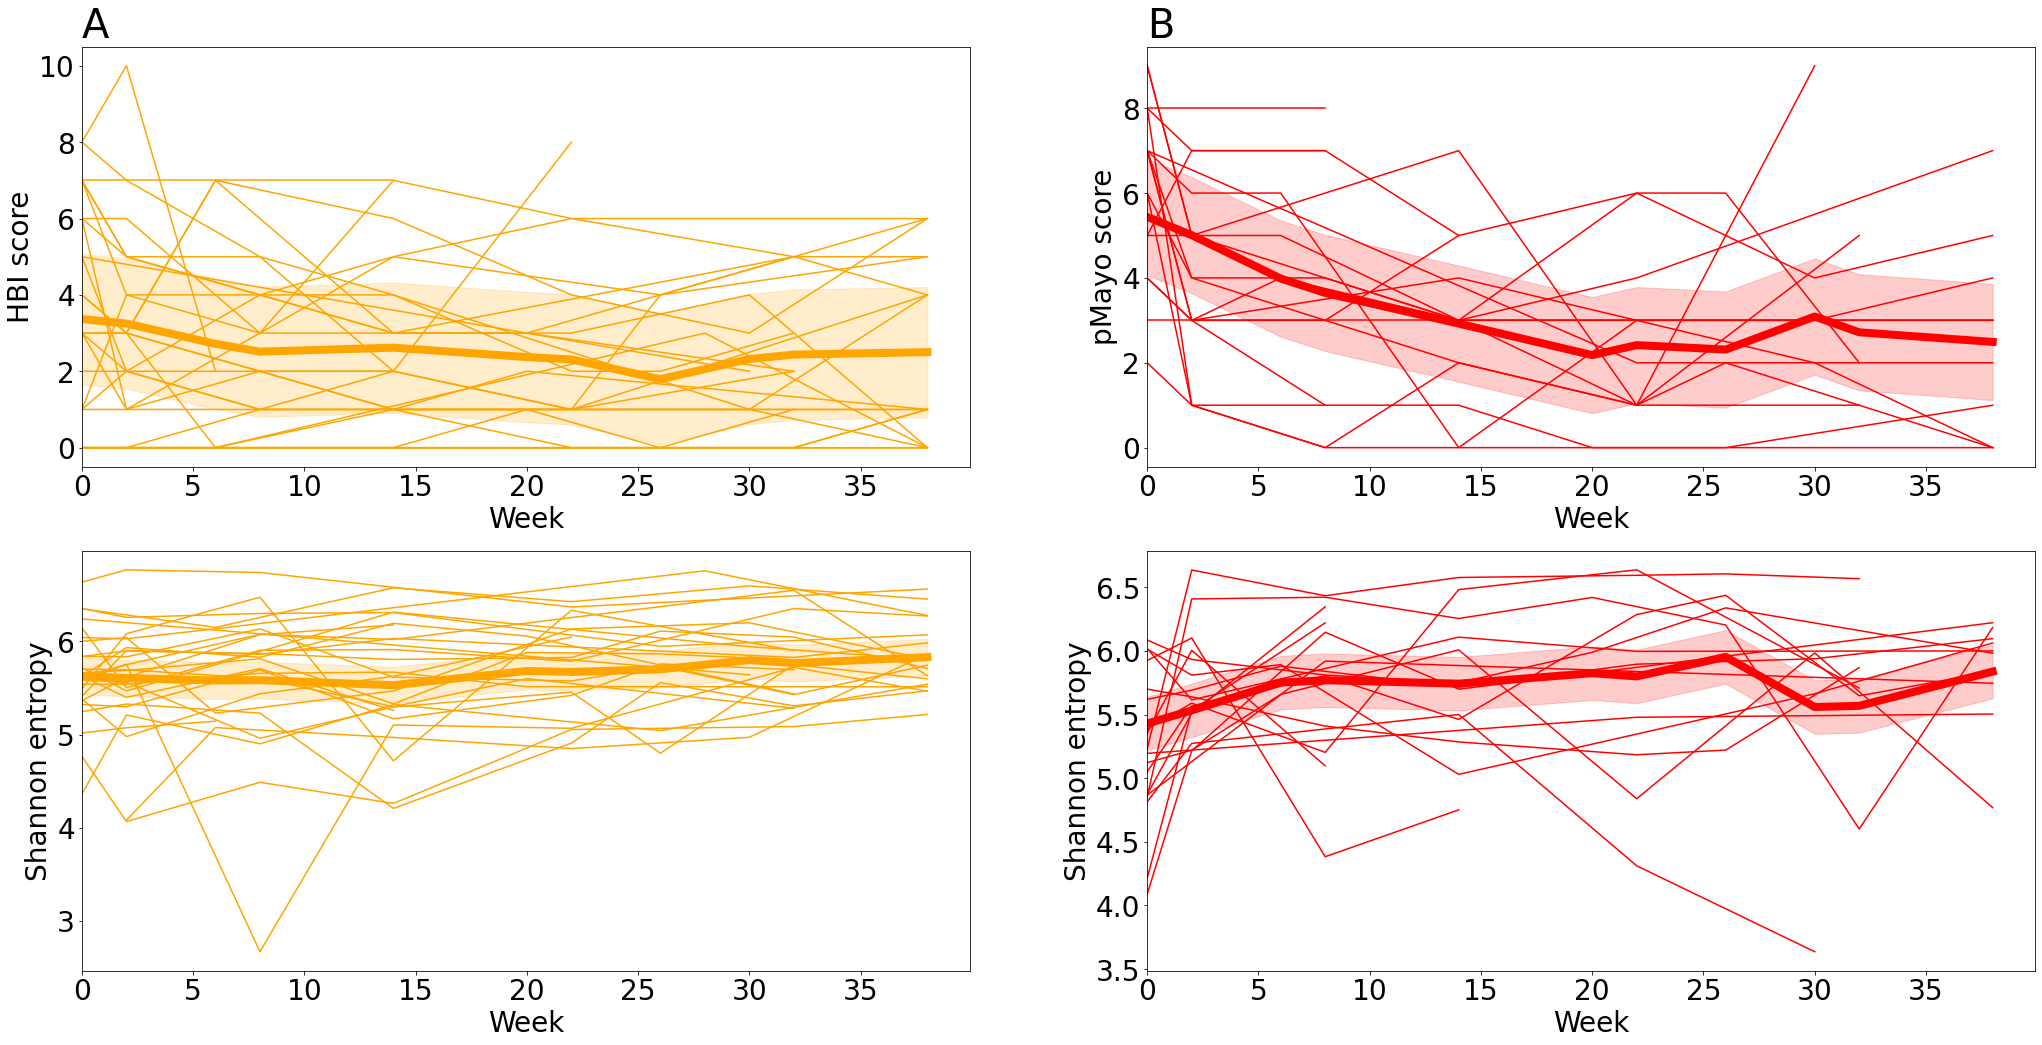

In [16]:
f1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(35,17))

# plot all CD patients including trend line
for individual in patients_cd.keys():
    ax1.plot(patients_cd[individual]["Week_num"], patients_cd[individual]["HBI_num"], label = individual, color = 'orange')
ax1.plot(pred_lowess_cd_hbi["Week_pred"], pred_lowess_cd_hbi["HBI_pred_lowess"], linewidth=8, color = 'orange')
ax1.fill_between(pred_lowess_cd_hbi["Week_pred"], (pred_lowess_cd_hbi["HBI_pred_lowess"]-ci_cd_hbi), (pred_lowess_cd_hbi["HBI_pred_lowess"]+ci_cd_hbi), color='orange', alpha=.2)
ax1.set_xlim(xmin=0)
ax1.set_title('A', fontsize=40, loc='left')
ax1.set_ylabel('HBI score', fontsize=28)
ax1.set_xlabel('Week', fontsize=28)
ax1.tick_params(axis='both', labelsize=28)

# plot all UC patients including trend line
for individual in patients_uc.keys():
    ax2.plot(patients_uc[individual]["Week_num"], patients_uc[individual]["pMayo_num"], label = individual, color = 'red')
ax2.plot(pred_lowess_uc_pmayo["Week_pred"], pred_lowess_uc_pmayo["pMayo_pred_lowess"], linewidth=8, color = 'red')
ax2.fill_between(pred_lowess_uc_pmayo["Week_pred"], (pred_lowess_uc_pmayo["pMayo_pred_lowess"]-ci_uc_pmayo), (pred_lowess_uc_pmayo["pMayo_pred_lowess"]+ci_uc_pmayo), color='red', alpha=.2)
ax2.set_xlim(xmin=0)
ax2.set_title('B', fontsize=40, loc='left')
ax2.set_ylabel('pMayo score', fontsize=28)
ax2.set_xlabel('Week', fontsize=28)
ax2.tick_params(axis='both', labelsize=28)

# plot all CD patients including trend line
for individual in patients_cd.keys():
    ax3.plot(patients_cd[individual]["Week_num"], patients_cd[individual]["Shannon_entropy"], label = individual, color = 'orange')
ax3.plot(pred_lowess_cd_shannon["Week_pred"], pred_lowess_cd_shannon["Shannon_pred_lowess"], linewidth=8, color = 'orange')
ax3.fill_between(pred_lowess_cd_shannon["Week_pred"], (pred_lowess_cd_shannon["Shannon_pred_lowess"]-ci_cd_sh), (pred_lowess_cd_shannon["Shannon_pred_lowess"]+ci_cd_sh), color='orange', alpha=.2)
ax3.set_xlim(xmin=0)
#ax3.set_title('CD', fontsize=40)
ax3.set_ylabel('Shannon entropy', fontsize=28)
ax3.set_xlabel('Week', fontsize=28)
ax3.tick_params(axis='both', labelsize=28)

# plot all UC patients including trend line
for individual in patients_uc.keys():
    ax4.plot(patients_uc[individual]["Week_num"], patients_uc[individual]["Shannon_entropy"], label = individual, color = 'red')
ax4.plot(pred_lowess_uc_shannon["Week_pred"], pred_lowess_uc_shannon["Shannon_pred_lowess"], linewidth=8, color = 'red')
ax4.fill_between(pred_lowess_uc_shannon["Week_pred"], (pred_lowess_uc_shannon["Shannon_pred_lowess"]-ci_uc_sh), (pred_lowess_uc_shannon["Shannon_pred_lowess"]+ci_uc_sh), color='red', alpha=.2)
ax4.set_xlim(xmin=0)
#ax4.set_title('UC', fontsize=40)
ax4.set_ylabel('Shannon entropy', fontsize=28)
ax4.set_xlabel('Week', fontsize=28)
ax4.tick_params(axis='both', labelsize=28)

f1.savefig('/Users/dagmarschierova/MEGA/MBÚ/TNF/NGS/runs_merged/outputs/qiime_results_B/diversity_Large_cohort/Clinical_scores_&_Shannon_in_time-lowess.png')

## Create plots with healthy controls

In [17]:
# create a dictionary having individual patients as keys
patients_hc = dict()
for individual in hc['Patient'].unique():
    patients_hc[individual] = hc[(hc['Patient'] == individual)][["Week_num","Visit_num","Shannon_entropy"]]

In [18]:
# sort the values according to week number and drop NA
for individual in patients_hc.keys():
    patients_hc[individual].sort_values('Week_num', inplace=True)
    patients_hc[individual].dropna(inplace=True)

In [19]:
hc_lowess = hc[['Shannon_entropy','Week_num']].dropna()

In [20]:
# create a reg model
X = hc_lowess['Week_num'].to_numpy().reshape(-1,1)
y = hc_lowess['Shannon_entropy'].to_numpy()
mod = LowessRegression(sigma=1).fit(X, y)

# predict with the model
x_pred = np.array([0,2,26,28]).reshape(-1, 1)
y_pred = mod.predict(x_pred)
y_pred = pd.DataFrame(y_pred).rename(columns={0: "Shannon_pred_lowess"})
y_pred

# create a df with predicted values
pred_lowess_hc_shannon = y_pred.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_hc_shannon

# calculate confidence interval
ci_hc_sh = 1.96 * np.std(hc_lowess["Shannon_entropy"])/np.mean(hc_lowess["Shannon_entropy"])

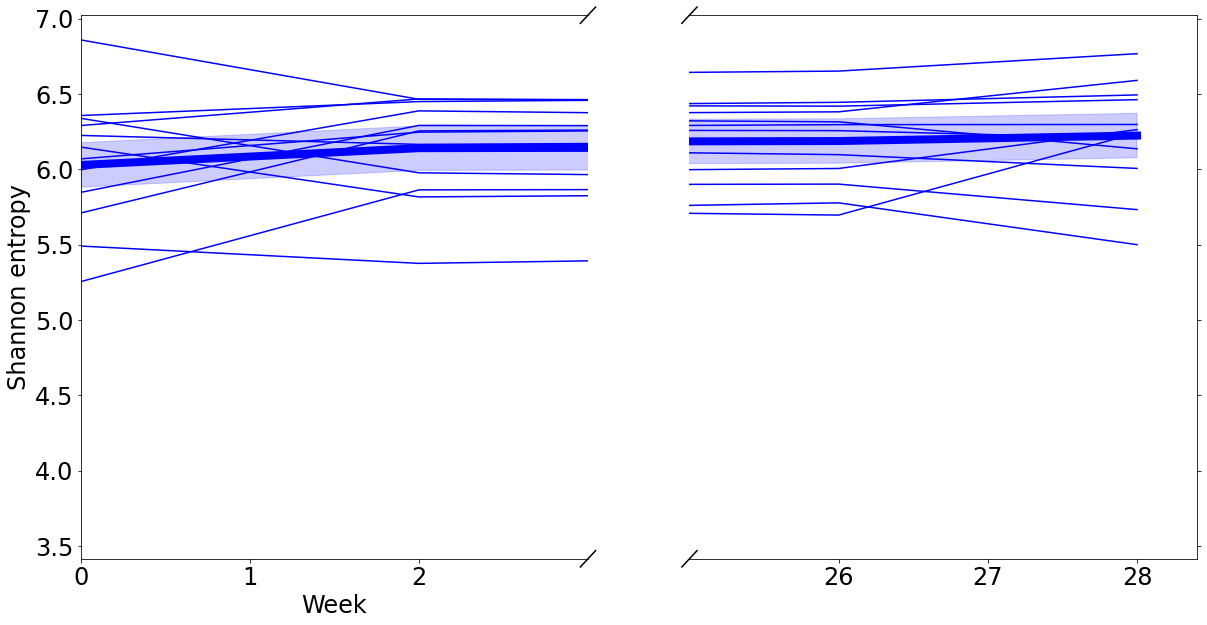

In [21]:
# create 2 subplots for broken axis with shared y
f4, (ax1,ax2) = plt.subplots(1,2,sharey=True, facecolor='w', figsize=(20,10))

# plot all HC individuals including trend line
for individual in patients_hc.keys():
    ax1.plot(patients_hc[individual]["Week_num"], patients_hc[individual]["Shannon_entropy"], label = individual, color = 'blue')
ax1.plot(pred_lowess_hc_shannon["Week_pred"], pred_lowess_hc_shannon["Shannon_pred_lowess"], linewidth=8, color = 'blue')
ax1.fill_between(pred_lowess_hc_shannon["Week_pred"], (pred_lowess_hc_shannon["Shannon_pred_lowess"]-ci_hc_sh), (pred_lowess_hc_shannon["Shannon_pred_lowess"]+ci_hc_sh), color='blue', alpha=.2)
ax1.set_xlim(xmin=0, xmax=3)
#ax1.set_title('HC', fontsize=24)
ax1.set_ylabel('Shannon entropy', fontsize=24)
ax1.set_xlabel('Week', fontsize=24)
ax1.tick_params(axis='both', labelsize=24)
ax1.xaxis.set_ticks(np.arange(0, 3, 1))

# plot the second grapf with same data and different x lims
for individual in patients_hc.keys():
    ax2.plot(patients_hc[individual]["Week_num"], patients_hc[individual]["Shannon_entropy"], label = individual, color = 'blue')
ax2.plot(pred_lowess_hc_shannon["Week_pred"], pred_lowess_hc_shannon["Shannon_pred_lowess"], linewidth=8, color = 'blue')
ax2.fill_between(pred_lowess_hc_shannon["Week_pred"], (pred_lowess_hc_shannon["Shannon_pred_lowess"]-ci_hc_sh), (pred_lowess_hc_shannon["Shannon_pred_lowess"]+ci_hc_sh), color='blue', alpha=.2)
ax2.set_xlim(xmin=25, xmax=28.4)
ax2.tick_params(axis='both', labelsize=24)
ax2.xaxis.set_ticks(np.arange(26, 28.4, 1))


# hide the spines between ax1 and ax2
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
#ax1.tick_params(labelright='off')


d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d), (1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)



f4.savefig('/Users/dagmarschierova/MEGA/MBÚ/TNF/NGS/runs_merged/outputs/qiime_results_B/diversity_HC_longitudinal/Shannon_in_time-week.png')

# Negative correlation between Shannon and clinical scores

In [22]:
# create a dictionary having individual patients as keys
patients_cd = dict()
for individual in cd['Patient'].unique():
    patients_cd[individual] = cd[(cd['Patient'] == individual)][["Week_num","HBI_num","Shannon_entropy","CD_localisation"]]

patients_uc = dict()
for individual in uc['Patient'].unique():
    patients_uc[individual] = uc[(uc['Patient'] == individual)][["Week_num","pMayo_num","Shannon_entropy","UC_extent"]]

In [23]:
# sort the values according to week number and drop NA
for individual in patients_cd.keys():
    patients_cd[individual].sort_values('HBI_num', inplace=True)
    patients_cd[individual].dropna(inplace=True)
    
for individual in patients_uc.keys():
    patients_uc[individual].sort_values('pMayo_num', inplace=True)
    patients_uc[individual].dropna(inplace=True)

In [24]:
cd_lowess_corr = cd[['HBI_num','Shannon_entropy']].dropna()
uc_lowess_corr = uc[['pMayo_num','Shannon_entropy']].dropna()

#### Create a model for CD Shannon vs HBI

In [25]:
# create a reg model
X = cd_lowess_corr['HBI_num'].to_numpy().reshape(-1,1)
y = cd_lowess_corr['Shannon_entropy'].to_numpy()
mod = LowessRegression(sigma=2).fit(X, y)

# predict with the model
x_pred = np.arange(start=0, stop=11, step=1).reshape(-1, 1)
y_pred = mod.predict(x_pred)
y_pred = pd.DataFrame(y_pred).rename(columns={0: "Shannon_pred_lowess"})
y_pred

# create a df with predicted values
pred_lowess_corr_cd_shannon = y_pred.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "HBI_pred"})
pred_lowess_corr_cd_shannon

# calculate confidence interval
ci_cd_corr_shannon = 1.96 * np.std(cd_lowess_corr["Shannon_entropy"])/np.mean(cd_lowess_corr["Shannon_entropy"])

#### Create a model for UC Shannon vs pMayo

In [26]:
# create a reg model
X = uc_lowess_corr['pMayo_num'].to_numpy().reshape(-1,1)
y = uc_lowess_corr['Shannon_entropy'].to_numpy()
mod = LowessRegression(sigma=2).fit(X, y)

# predict with the model
x_pred = np.arange(start=0, stop=10, step=1).reshape(-1, 1)
y_pred = mod.predict(x_pred)
y_pred = pd.DataFrame(y_pred).rename(columns={0: "Shannon_pred_lowess"})
y_pred

# create a df with predicted values
pred_lowess_corr_uc_shannon = y_pred.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "pMayo_pred"})
pred_lowess_corr_uc_shannon

# calculate confidence interval
ci_uc_corr_shannon = 1.96 * np.std(uc_lowess_corr["Shannon_entropy"])/np.mean(uc_lowess_corr["Shannon_entropy"])

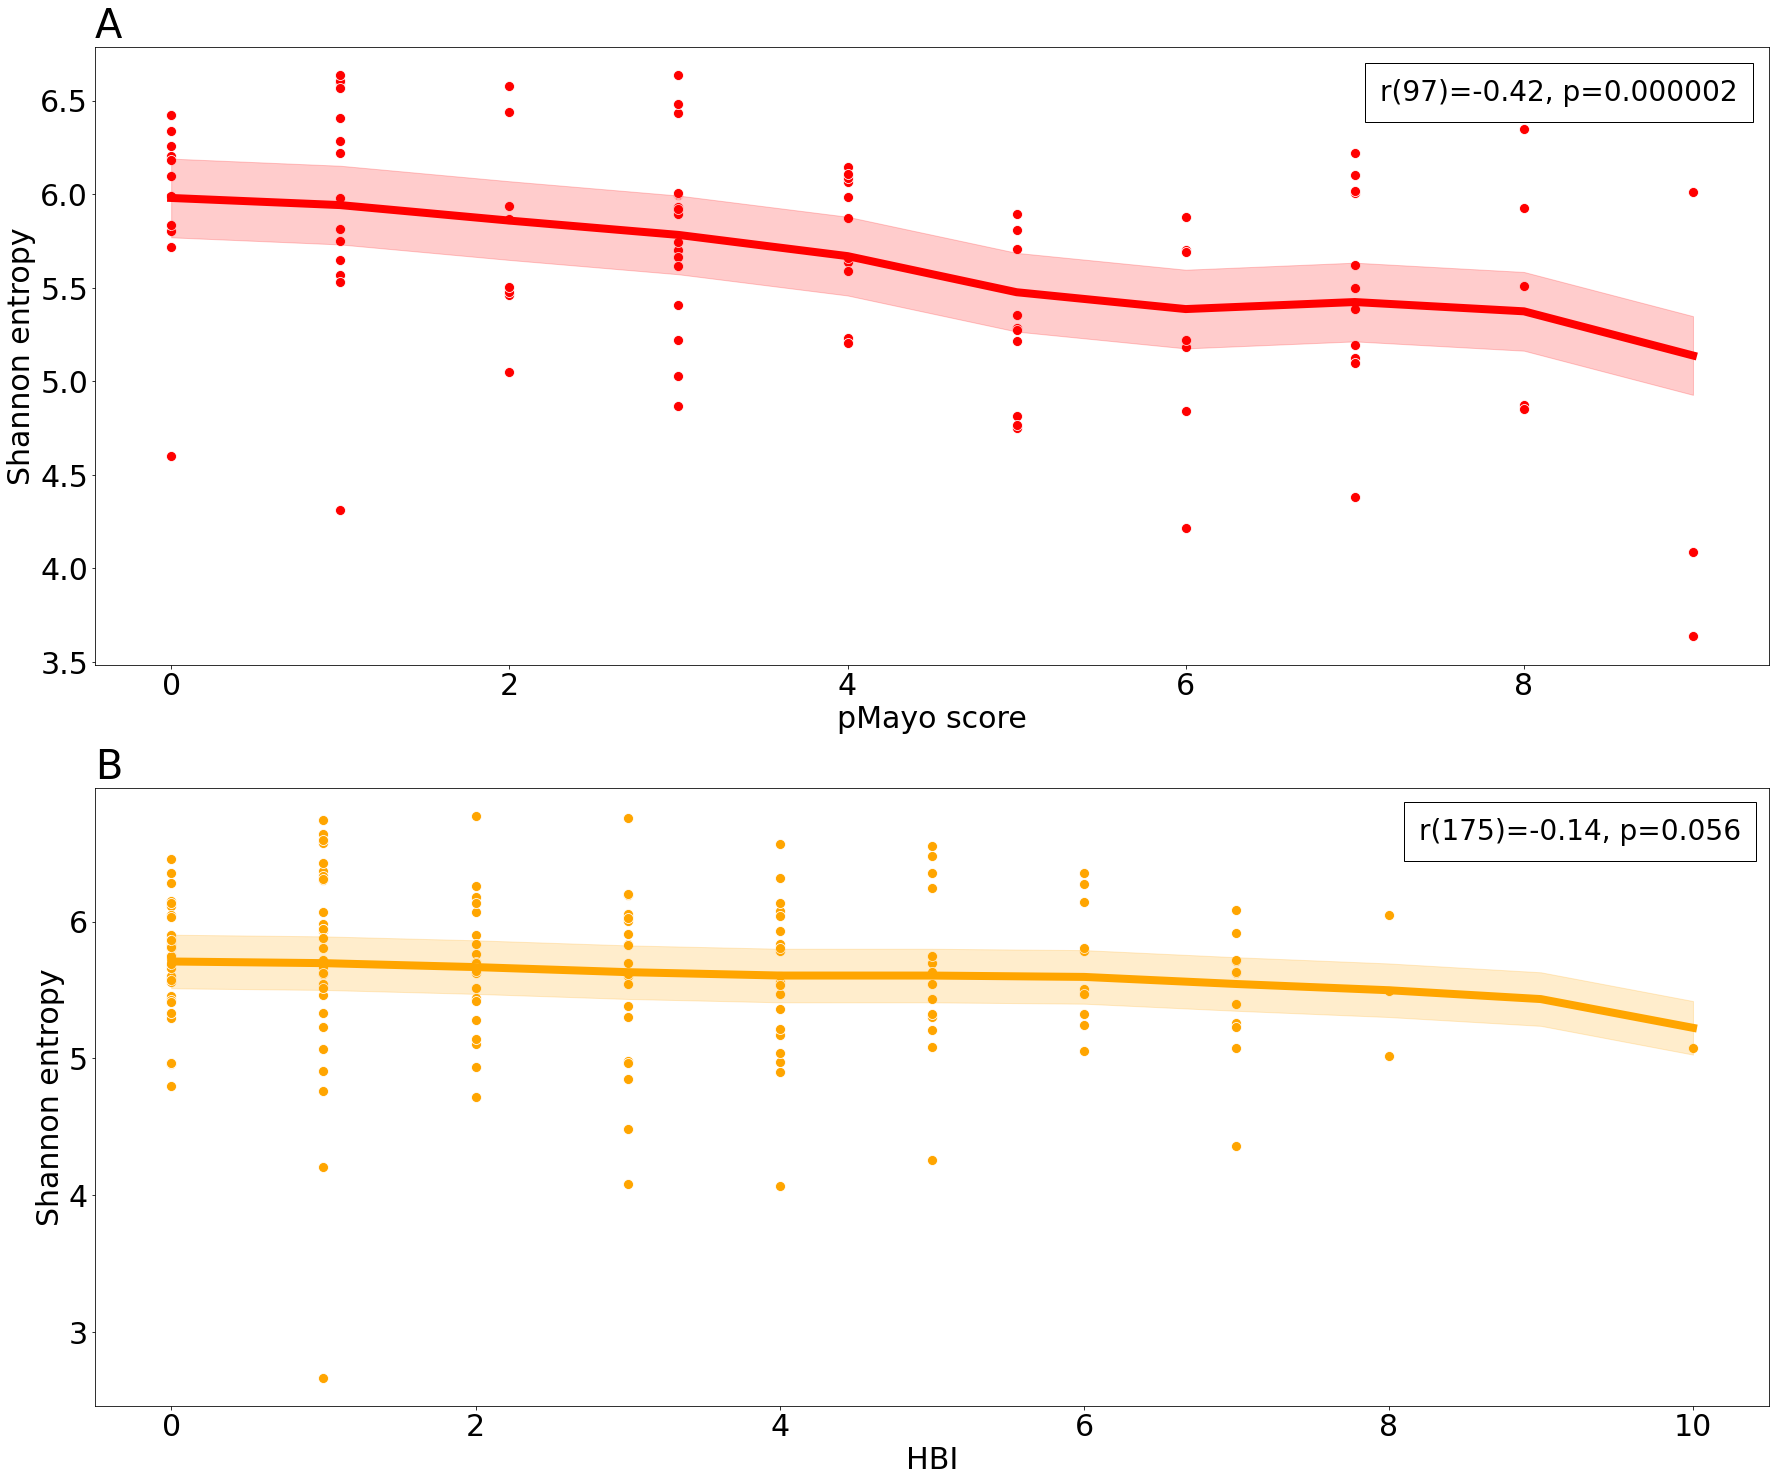

In [35]:
f5, (ax1, ax2) = plt.subplots(2, 1, figsize=(30,25))

# plot all UC patients including mean line
sns.scatterplot(ax=ax1, x=uc_lowess_corr["pMayo_num"], y=uc_lowess_corr["Shannon_entropy"], color='red', 
                y_jitter=10, s=100)
ax1.plot(pred_lowess_corr_uc_shannon["pMayo_pred"], pred_lowess_corr_uc_shannon["Shannon_pred_lowess"], linewidth=8, color = 'red')
ax1.fill_between(pred_lowess_corr_uc_shannon["pMayo_pred"], (pred_lowess_corr_uc_shannon["Shannon_pred_lowess"]-ci_uc_corr_shannon), (pred_lowess_corr_uc_shannon["Shannon_pred_lowess"]+ci_uc_corr_shannon), color='red', alpha=.2)
ax1.set_title('A', loc='left', fontsize=40)
ax1.set_ylabel('Shannon entropy', fontsize=30)
ax1.set_xlabel('pMayo score', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.text(7.15, 6.5, "r(97)=-0.42, p=0.000002", bbox={'facecolor': 'white', 'pad': 15}, fontsize=28)

# plot all CD patients including mean line
sns.scatterplot(ax=ax2, x=cd_lowess_corr["HBI_num"], y=cd_lowess_corr["Shannon_entropy"], color='orange', 
                y_jitter=10, s=100)
ax2.plot(pred_lowess_corr_cd_shannon["HBI_pred"], pred_lowess_corr_cd_shannon["Shannon_pred_lowess"], linewidth=8, color = 'orange')
ax2.fill_between(pred_lowess_corr_cd_shannon["HBI_pred"], (pred_lowess_corr_cd_shannon["Shannon_pred_lowess"]-ci_cd_corr_shannon), (pred_lowess_corr_cd_shannon["Shannon_pred_lowess"]+ci_cd_corr_shannon), color='orange', alpha=.2)
ax2.set_title('B', loc='left', fontsize=40)
ax2.set_ylabel('Shannon entropy', fontsize=30)
ax2.set_xlabel('HBI', fontsize=30)
ax2.tick_params(axis='both', labelsize=30)
ax2.text(8.2, 6.6, "r(175)=-0.14, p=0.056", bbox={'facecolor': 'white', 'pad': 15}, fontsize=28)

f5.savefig('/Users/dagmarschierova/MEGA/MBÚ/TNF/NGS/runs_merged/outputs/qiime_results_B/diversity_Large_cohort/Shannon_on_clinical_scores-lowess.png')

In [28]:
stats.spearmanr(cd_lowess_corr["HBI_num"], cd_lowess_corr["Shannon_entropy"], nan_policy='omit')

SpearmanrResult(correlation=-0.14436464066898944, pvalue=0.05592850808955841)

In [29]:
stats.spearmanr(uc_lowess_corr["pMayo_num"], uc_lowess_corr["Shannon_entropy"], nan_policy='omit')

SpearmanrResult(correlation=-0.4178270045108321, pvalue=1.8628359629021094e-05)